In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import matplotlib as mpl

import re

In [12]:
columns = [
    "From Problem",
    "To Problem",
    "Year",
    "Blow-Up",
    "Sparse Blow Up",
    "Preserves Sparse?",
    "Parsimonious"
]


reductions = pd.read_csv('KarpReductions.csv', usecols=columns)

In [13]:
def draw(matrix):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))

    # Hide axes
    ax.set_frame_on(False)
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 

    # Create table
    table = ax.table(cellText=matrix.values, colLabels=matrix.columns, rowLabels=matrix.index, 
                    cellLoc="center", loc="center")

    # Adjust layout
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width([i for i in range(len(matrix.index))])  # Adjust column width

    plt.show()

In [14]:
# Here we process everything and make our dictonaries

directReductions = {}
blowUps = {}
spBlowUps = {}
parsReductions = {}

for i in range(len(reductions)):
    fromProblem = reductions["From Problem"][i] 
    toProblem = reductions["To Problem"][i] 
    blowUp = reductions["Blow-Up"][i] 
    spBlowUp = reductions["Sparse Blow Up"][i]
    pars = reductions["Parsimonious"][i] 
    preserv = reductions["Preserves Sparse?"][i]

    # Regular Problem
    redProb = (fromProblem, toProblem)

    directReductions[redProb] = "y"

    if blowUp != "x":
        blowUp = int(blowUp)
        if redProb in blowUps.keys():
            if blowUp < blowUps[redProb]:
                blowUps[redProb] = blowUp
        else:
            blowUps[redProb] = blowUp

    # Sparse problem
    sparseRed = ("Sparse-" + fromProblem, toProblem)
    if spBlowUp != "?":
        spBlowUp = int(spBlowUp)
        if sparseRed in spBlowUps.keys():
            if spBlowUp < spBlowUps[sparseRed]:
                    spBlowUps[sparseRed] = spBlowUp
        else:
            spBlowUps[sparseRed] = spBlowUp

        if preserv == "Yes":
            sparseRed = ("Sparse-" + fromProblem, "Sparse-" + toProblem)
            spBlowUp = int(spBlowUp)
            if sparseRed in spBlowUps.keys():
                if spBlowUp < spBlowUps[sparseRed]:
                        spBlowUps[sparseRed] = spBlowUp
            else:
                spBlowUps[sparseRed] = spBlowUp

    

# Extract unique problem names
problems = sorted(set([key[0] for key in directReductions.keys()] + 
                    [key[1] for key in directReductions.keys()]))

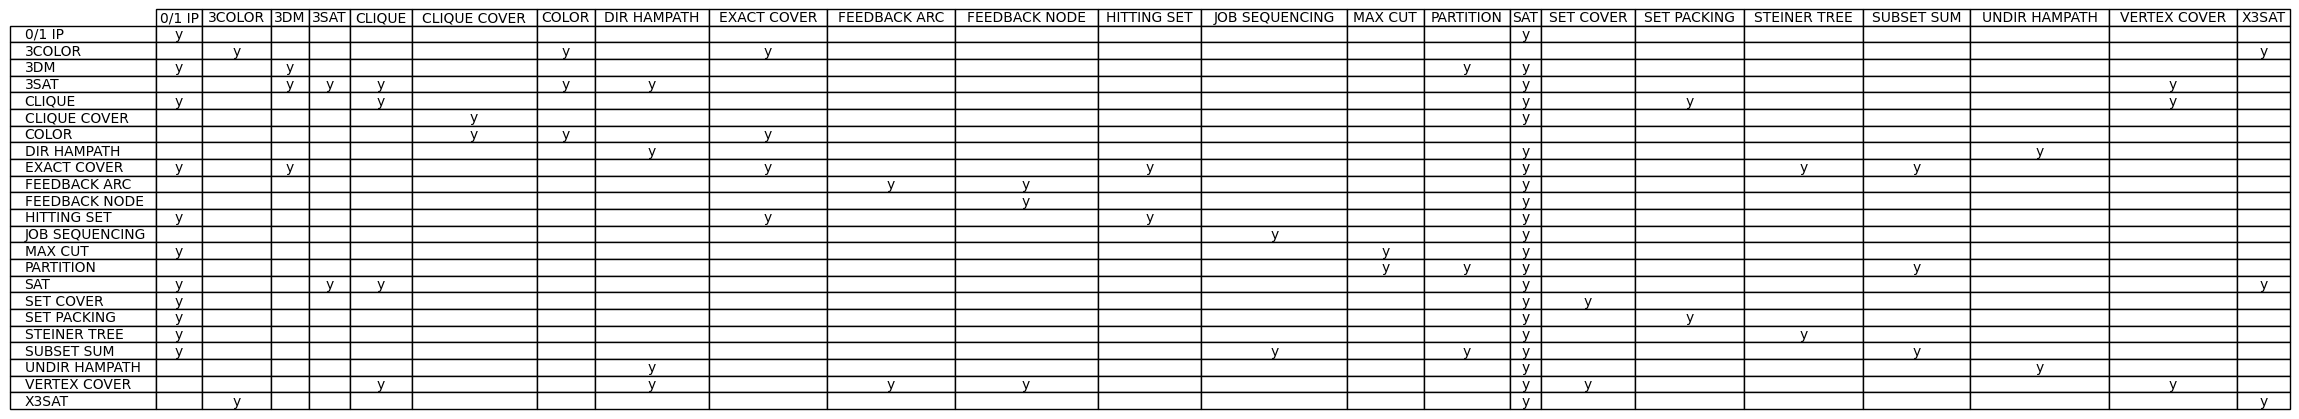

In [15]:
# Create an empty adjacency matrix (DataFrame)
matrix = pd.DataFrame("", index=problems, columns=problems)

# Fill the matrix where reductions exist
for (fromProblem, toProblem), value in directReductions.items():
    matrix.loc[fromProblem, toProblem] = value

# Set diagonal elements to "y"
for problem in problems:
    matrix.loc[problem, problem] = "y"

draw(matrix)


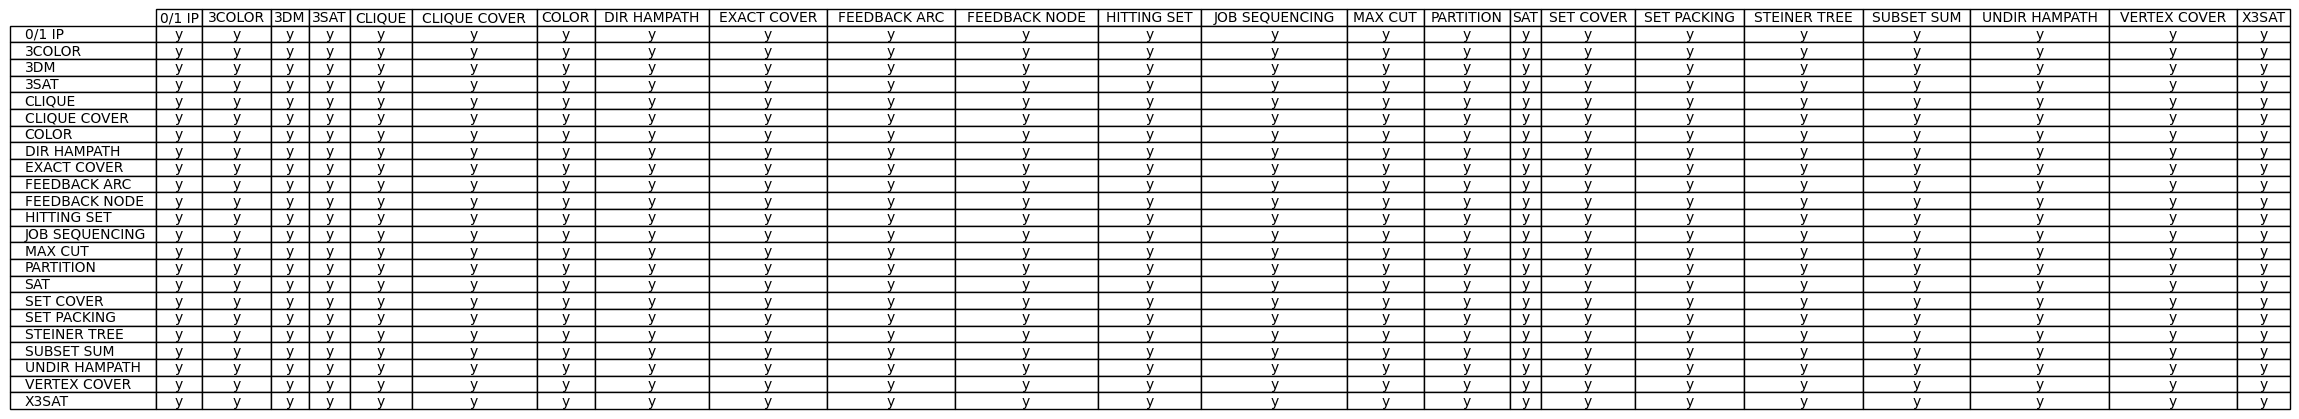

In [16]:
# If we take the transitive closure everything should be true

matrixTC = matrix.copy()

# Extract unique problem names
problems = sorted(set([key[0] for key in directReductions.keys()] + 
                      [key[1] for key in directReductions.keys()]))

for k in problems:
    for i in problems:
        for j in problems:
            if matrixTC.loc[i, k] == "y" and matrixTC.loc[k, j] == "y":
                matrixTC.loc[i, j] = "y"

draw(matrixTC)

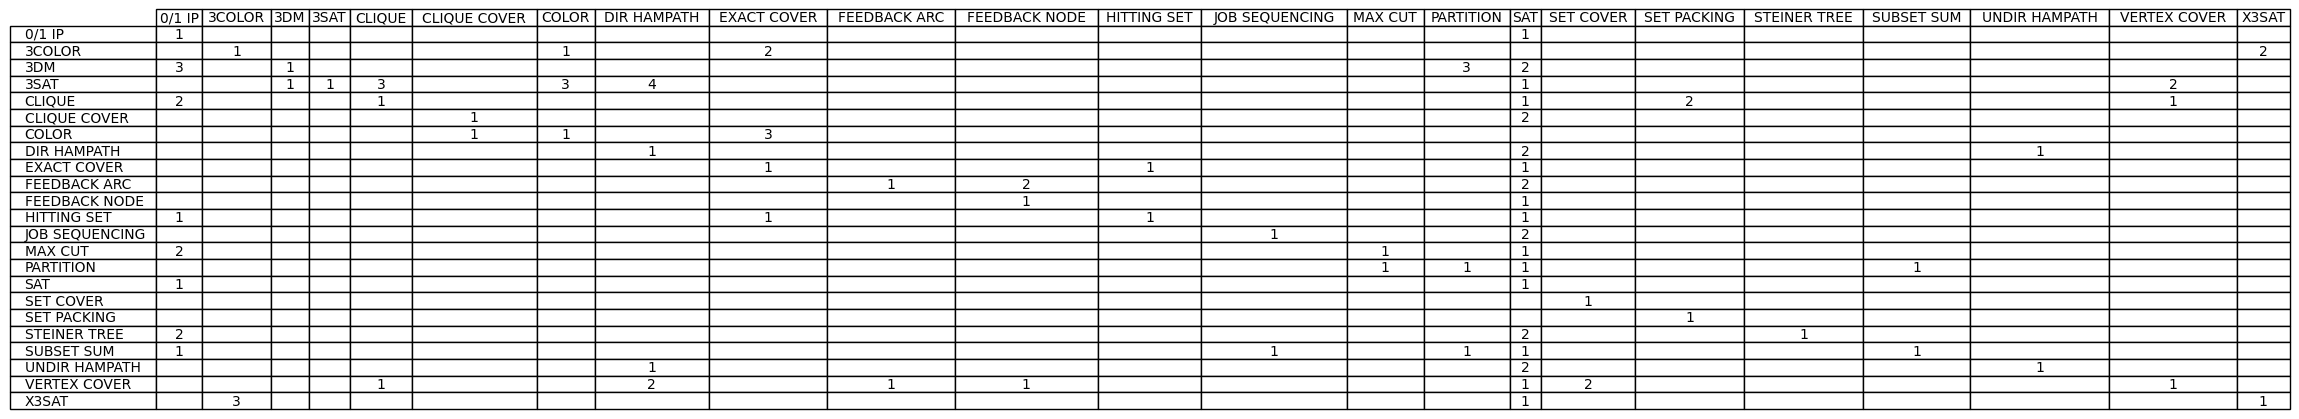

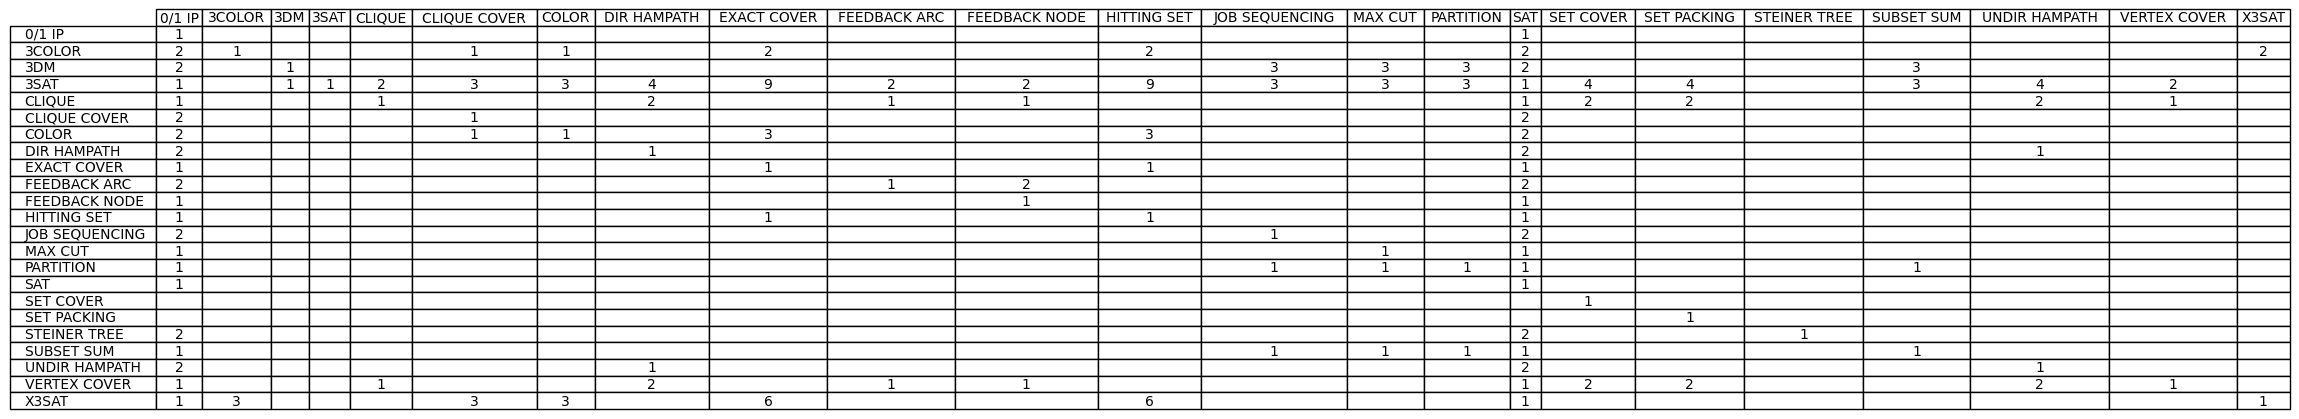

In [17]:
# Now we will track the blow up of reductions ignoring sparsity

# Create an empty adjacency matrix (DataFrame)
matrixBU = pd.DataFrame("", index=problems, columns=problems)

# Fill the matrix where reductions exist
for (fromProblem, toProblem), value in blowUps.items():
    matrixBU.loc[fromProblem, toProblem] = value

# Set diagonal elements to "y"
for problem in problems:
    matrixBU.loc[problem, problem] = 1

draw(matrixBU)

matBUTC = matrixBU.copy()

for k in problems:
    for i in problems:
        for j in problems:
            if matBUTC.loc[i, k] != "" and matBUTC.loc[k, j] != "":
                if matBUTC.loc[i,j] == "":
                    matBUTC.loc[i,j] = matBUTC.loc[i, k] * matBUTC.loc[k, j]
                else:
                    matBUTC.loc[i,j] = min(matBUTC.loc[i,j], matBUTC.loc[i, k] * matBUTC.loc[k, j])

draw(matBUTC)

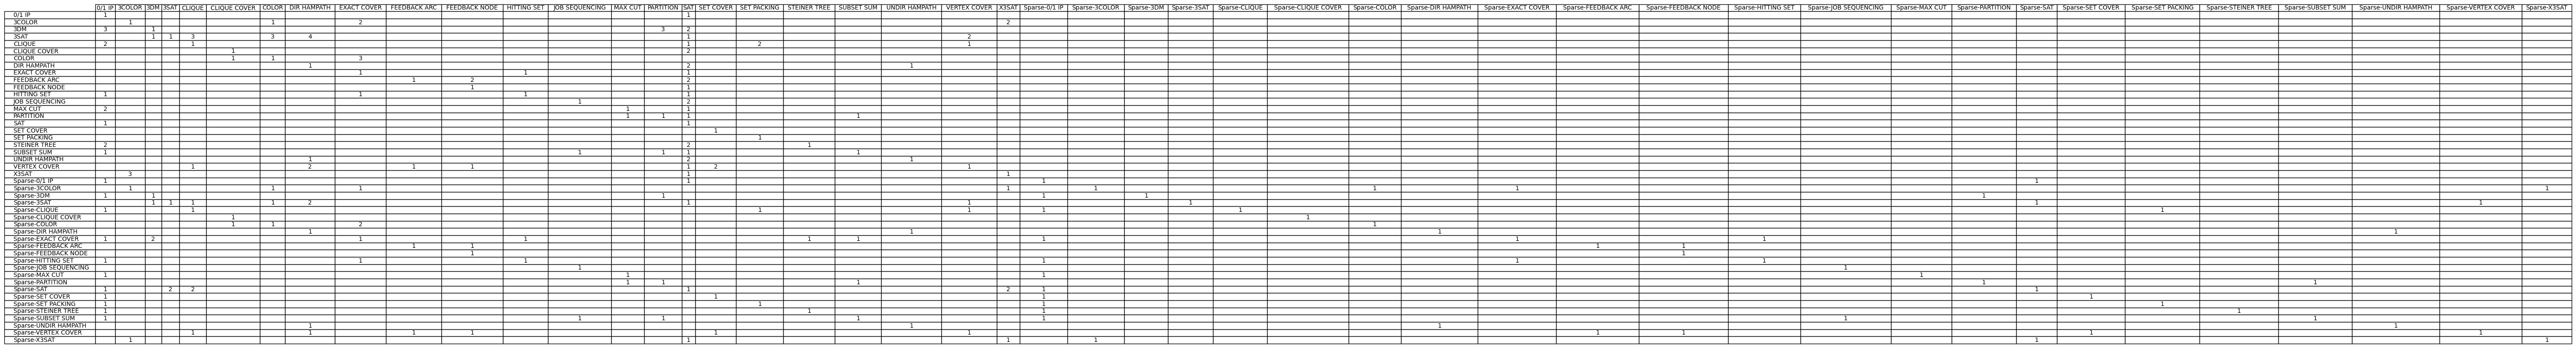

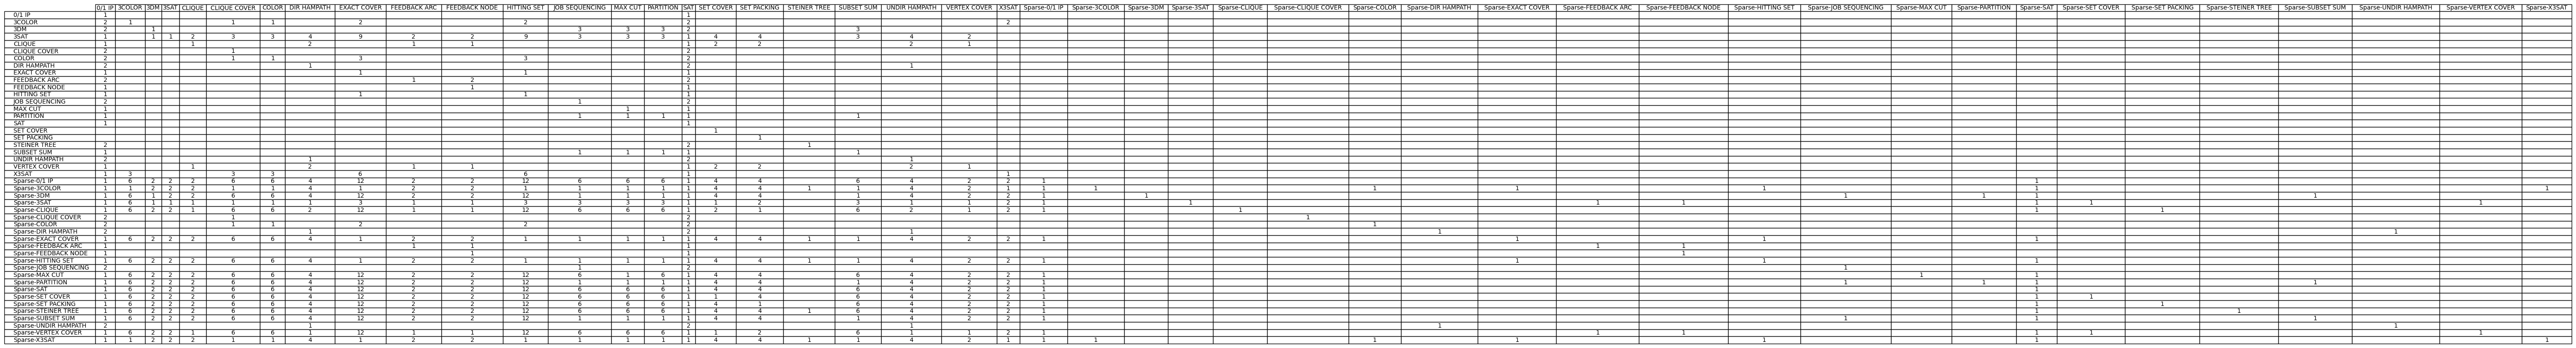

In [18]:
# Draw Table with Sparse Problems



sparseProblems = problems.copy()
for problem in problems:
    sparseProblems.append("Sparse-" + problem)

sparseMatrix = pd.DataFrame("", index=sparseProblems, columns=sparseProblems)

# Fill the matrix where reductions exist
for (fromProblem, toProblem), value in blowUps.items():
    sparseMatrix.loc[fromProblem, toProblem] = value
for (fromProblem, toProblem), value in spBlowUps.items():
    sparseMatrix.loc[fromProblem, toProblem] = value

# Set diagonal elements to "y"
for problem in problems:
    sparseMatrix.loc[problem, problem] = 1
    sparseMatrix.loc["Sparse-" + problem, problem] = 1
    sparseMatrix.loc["Sparse-" + problem, "Sparse-" + problem] = 1

draw(sparseMatrix)

sparseMatrixTC = sparseMatrix.copy()

for k in sparseProblems:
    for i in sparseProblems:
        for j in sparseProblems:
            if sparseMatrixTC.loc[i, k] != "" and sparseMatrixTC.loc[k, j] != "":
                if sparseMatrixTC.loc[i,j] == "":
                    sparseMatrixTC.loc[i,j] = sparseMatrixTC.loc[i, k] * sparseMatrixTC.loc[k, j]
                else:
                    sparseMatrixTC.loc[i,j] = min(sparseMatrixTC.loc[i,j], sparseMatrixTC.loc[i, k] * sparseMatrixTC.loc[k, j])

draw(sparseMatrixTC)

In [19]:
# Get Strongly Connected Components. 

# Step 1: Build the adjacency list from sparseMatrixTC (only weight 1 edges)
graph = nx.DiGraph()

for i in sparseMatrixTC.index:
    for j in sparseMatrixTC.columns:
        if sparseMatrixTC.loc[i, j] == 1:  # Only consider weight 1 edges
            graph.add_edge(i, j)

# Step 2: Compute Strongly Connected Components (SCCs)
sccs = list(nx.strongly_connected_components(graph))

# Step 3: Display the SCCs
for idx, scc in enumerate(sccs, 1):
    print(f"SCC {idx}: {sorted(scc)}")

SCC 1: ['0/1 IP', 'SAT']
SCC 2: ['CLIQUE COVER']
SCC 3: ['COLOR']
SCC 4: ['3COLOR']
SCC 5: ['3DM']
SCC 6: ['3SAT']
SCC 7: ['FEEDBACK ARC']
SCC 8: ['FEEDBACK NODE']
SCC 9: ['CLIQUE', 'VERTEX COVER']
SCC 10: ['DIR HAMPATH', 'UNDIR HAMPATH']
SCC 11: ['EXACT COVER', 'HITTING SET']
SCC 12: ['JOB SEQUENCING']
SCC 13: ['MAX CUT']
SCC 14: ['PARTITION', 'SUBSET SUM']
SCC 15: ['SET COVER']
SCC 16: ['SET PACKING']
SCC 17: ['STEINER TREE']
SCC 18: ['X3SAT']
SCC 19: ['Sparse-0/1 IP', 'Sparse-SAT']
SCC 20: ['Sparse-COLOR']
SCC 21: ['Sparse-EXACT COVER', 'Sparse-HITTING SET']
SCC 22: ['Sparse-3COLOR', 'Sparse-X3SAT']
SCC 23: ['Sparse-JOB SEQUENCING']
SCC 24: ['Sparse-SUBSET SUM']
SCC 25: ['Sparse-PARTITION']
SCC 26: ['Sparse-3DM']
SCC 27: ['Sparse-FEEDBACK NODE']
SCC 28: ['Sparse-FEEDBACK ARC']
SCC 29: ['Sparse-SET COVER']
SCC 30: ['Sparse-VERTEX COVER']
SCC 31: ['Sparse-3SAT']
SCC 32: ['Sparse-SET PACKING']
SCC 33: ['Sparse-CLIQUE']
SCC 34: ['Sparse-CLIQUE COVER']
SCC 35: ['Sparse-DIR HAMPATH', 'Spa

In [ ]:
nx.draw(graph)